In [1]:
%config Completer.use_jedi = False
import numpy as np
%load_ext autoreload

In [2]:
from sensor_msgs.msg import LaserScan, Illuminance,Image
from geometry_msgs.msg import Pose,Twist
from nav_msgs.msg import Odometry
from rosgraph_msgs.msg import Clock

import rospy as rp
rp.init_node('runner')

pub = rp.Publisher('/cmd_vel', Twist,queue_size=10)

In [3]:
from functools import partial


j = 3

qs = [0]*3

def setQi(x,i):
    global qs
    qs[i] = x.illuminance
    
    
odom = None

def setOdom(o):
    global odom
    odom = o
    
sc = []
    

def setSc(x):
    global sc
    sc = x.ranges
    
scans = rp.Subscriber("/scan",LaserScan,setSc)
subs = [rp.Subscriber("/light_sensor_plugin/lightSensor/camera_{}".format(i),Illuminance,partial(lambda x,k:setQi(x,k),k=i)) for i in range(j)]
cams = [rp.Subscriber("/camera_{}/rgb/image_raw".format(i),Image) for i in range(j)]
os = rp.Subscriber("/odom",Odometry,setOdom)


In [93]:
os.unregister()
scans.unregister()
for sub in subs:
    sub.unregister()
    
for cam in cams:
    cam.unregister()

In [74]:
moveStraight(pub,0)

In [4]:
%autoreload 2
from localisation import init_localisation,localisation_step,location_found,rotate,get_location,updateState,plot_location,moveStraight

In [12]:
rotate(pub,-np.pi/2,odom)

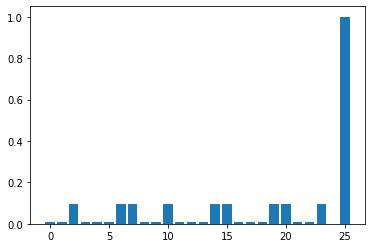

In [7]:
import matplotlib.pyplot as plt

init_localisation()
updateState(qs)
plot = plot_location()

In [5]:
from IPython.display import display,clear_output
import matplotlib.pyplot as plt

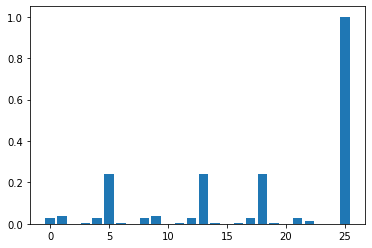

None

KeyboardInterrupt: 

In [8]:
rotate(pub,0,odom)
while not location_found():
    localisation_step(pub,qs,odom)
        
    rotate(pub,0,odom)
    
    clear_output()
    plot = plot_location()
    display(plt.show())
    
    j += 1
    
location = get_location()
location

In [78]:
plot.savefig('images/after_3_steps_location_hist.png', dpi=300)

In [13]:
from localisation import moveStraightForTime,rotate,abs_rotate

def drive(pub,v,odom):
    
    a =  np.arctan2(v[0],-v[1])
    rotate(pub,a,odom)
   
    d = np.sqrt((v**2).sum())
    moveStraightForTime(pub,0.05,2*d)

In [6]:
location = 7

In [7]:
pos = [3.1,2.8+location/10.0]
pos

[3.1, 3.5]

In [8]:

%autoreload 2

from planning import updateGrid,getRoute,grid,setGoal,fidelty
import matplotlib.pyplot as plt

In [27]:
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

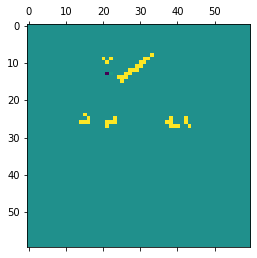

In [31]:
grid[:,:] = 0
#setGoal(2.6,0.7)
setGoal(2.1,1.35)
updateGrid(pos[0],pos[1],odom,sc)

plt.matshow(grid)
#plt.savefig('images/astart_inital.png', dpi=300)

In [29]:
plt.draw()

<Figure size 432x288 with 0 Axes>

In [193]:
moveStraightForTime(pub,0,0)

In [81]:
rotate(pub,0,odom)

In [9]:
def mask_in(xf,xt,yf,yt):
    xf = int(xf*fidelty)
    xt = int(xt*fidelty)
    yf = int(yf*fidelty)
    yt = int(yt*fidelty)
    
    n_x = (xt-xf)+1
    n_y = (yt-yf)+1
    x = np.linspace(xf,xt,n_x).astype(np.int)
    y = np.linspace(yf,yt,n_y).astype(np.int)
    
    X,Y = np.meshgrid(x,y)
    
    return list(zip(Y.ravel(),X.ravel()))

In [10]:
barrier = mask_in(2,4,2.6,2.75)
mask_right = mask_in(3.5,5.9,2,5.9)

In [34]:
illegal = barrier+mask_right

In [35]:
np.unique(grid)

array([-10.,   0.,   1.,  10.])

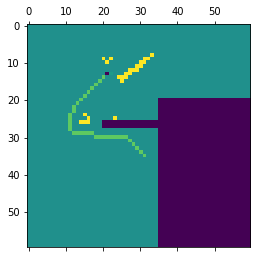

shutdown request: [/runner] Reason: new node registered with same name


In [36]:
path = getRoute(illegal)
result = np.copy(grid)

for node in path:
    result[node[0],node[1]] = 5
    
for node in illegal:
    result[node[0],node[1]] = -10

clear_output()
plt.matshow(result)

In [184]:
pos

[3.1, 3.45]

6.275905007806259
-0.007280299373327637


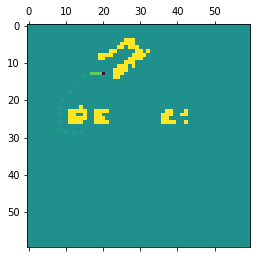

None

[2. 0.] [1.7999999999999994, 1.3999999999999988]


In [54]:
while True:
    updateGrid(pos[0],pos[1],odom,sc)
    path = getRoute(illegal)
    
    if path == None:
        grid[:,:] = 0
        continue
    
    if len(path) < 3:
        break        
    
    closest = path[-4:]

    a = closest[0]
    b = closest[-1]
    v = -np.array((b[1]-a[1],b[0]-a[0]))*fidelty/10

    result = np.copy(grid)

    for node in path:
        result[node[0],node[1]] = 5

    clear_output()
    plt.matshow(result)
    display(plt.show())
    print(v,pos)
    
    drive(pub,v,odom)
    
    pos[0] += v[0]/fidelty
    pos[1] += v[1]/fidelty
    #break
    
rotate(pub,np.pi/4,odom)

#import numpy as np
#result = np.copy(grid)

#for node in route.getPath():
#    result[node.x,node.y] = 5

  
    
#print(v)
#plt.matshow(result)

In [56]:
[1,2,3,4][-5:]

[1, 2, 3, 4]

shutdown request: [/runner] Reason: new node registered with same name


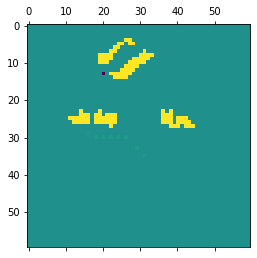

In [51]:
plt.matshow(grid)

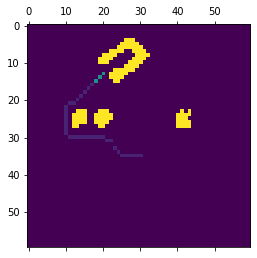

In [87]:
plt.matshow(result)
plt.savefig('images/astar_A3.png', dpi=300)

In [122]:
rotate(pub,np.pi/4,odom)

In [117]:
left = np.mean([min(v,1) for v in sc[:100]])
right = np.mean([min(v,1) for v in sc[-100:]])

In [118]:
left

0.7621731644868851

In [119]:
right

0.8333364269137382

In [123]:
rotate(pub,np.pi/4,odom)

while True:
    d = np.mean(sc[:10]+sc[-10:])
    
    if d < 0.25:
        break
        
    t = 2
        
    if d < 0.5:
        t = 2*d
    
    left = np.mean([min(v,1) for v in sc[80:100]])
    right = np.mean([min(v,1) for v in sc[-100:-80]])
    
    if left < 0.2:
        abs_rotate(pub,0.4,odom)
    if right < 0.2:
        abs_rotate(pub,-0.4,odom)
        
    moveStraightForTime(pub,0.05,t)    
    rotate(pub,np.pi/4,odom)

In [331]:
np.rad2deg(0.5)

28.64788975654116

In [124]:
rotate(pub,np.pi/4,odom)

In [151]:
rotate(pub,np.pi/4,odom)
while True:
    d = np.mean(sc[:10]+sc[-10:])
    
    if d > 1.5:
        break
        
    t = 2
        
    if d > 1.25:
        t = 2*d
        
    moveStraightForTime(pub,-0.05,t)    
    rotate(pub,np.pi/4,odom)
    
    k = -0.05*t
    pos[0] += k
    pos[1] -= k
    
rotate(pub,np.pi/4,odom)

In [89]:
pos

[1.4536412280797952, 2.166358771920205]

In [11]:
pos = [1.8,1.85]

In [12]:
mask_left = mask_in(0,2.5,2.5,5.9)
bad = mask_left + barrier

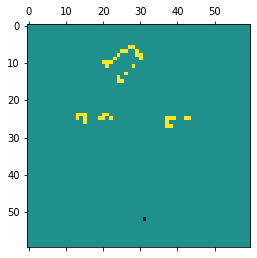

In [14]:
%autoreload 2
from planning import updateGrid,getRoute,grid,setGoal,fidelty
grid[:,:] = 0
setGoal(3.1,5.2)
updateGrid(pos[0],pos[1],odom,sc)


plt.matshow(grid)

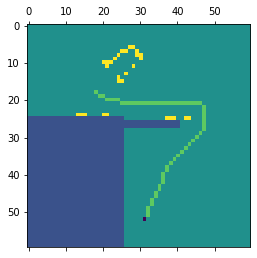

In [15]:
path = getRoute(bad,3)
result = np.copy(grid)

for node in path:
    result[node[0],node[1]] = 5
    
    
for node in bad:
    result[node[0],node[1]] = -5

plt.matshow(result)

In [68]:
path

[(51, 30),
 (50, 29),
 (49, 29),
 (48, 29),
 (47, 29),
 (46, 29),
 (45, 29),
 (44, 29),
 (43, 29),
 (42, 29),
 (41, 29),
 (40, 29),
 (39, 29),
 (38, 29),
 (37, 29),
 (36, 29),
 (35, 29),
 (34, 29),
 (33, 29),
 (32, 29),
 (31, 29),
 (30, 29),
 (29, 29),
 (28, 29),
 (27, 29),
 (26, 29),
 (25, 29),
 (24, 29),
 (23, 29),
 (22, 29),
 (21, 28),
 (21, 27),
 (21, 26),
 (21, 25),
 (21, 24),
 (20, 23),
 (20, 22),
 (20, 21),
 (20, 20),
 (19, 19),
 (18, 18)]

In [101]:
[(x,x.cost()) for x in clist.intersection(path)]

[((24,46) 78.97056274847714, 35.97056274847714),
 ((39,35) 72.52691193458116, 55.52691193458116),
 ((20,24) 46.82842712474619, 7.82842712474619),
 ((21,37) 61.55634918610405, 24.55634918610405),
 ((20,21) 46.82842712474619, 4.82842712474619),
 ((38,36) 73.11269837220806, 54.112698372208065),
 ((21,25) 46.242640687119284, 9.242640687119286),
 ((21,38) 63.55634918610405, 25.55634918610405),
 ((37,37) 73.69848480983498, 52.69848480983497),
 ((22,26) 45.65685424949238, 10.656854249492381),
 ((21,39) 65.55634918610406, 26.55634918610405),
 ((36,38) 74.28427124746187, 51.28427124746188),
 ((21,40) 67.55634918610406, 27.55634918610405),
 ((23,27) 45.071067811865476, 12.071067811865477),
 ((35,39) 74.8700576850888, 49.87005768508879),
 ((21,41) 69.55634918610406, 28.55634918610405),
 ((24,28) 44.485281374238575, 13.485281374238573),
 ((34,40) 75.45584412271569, 48.455844122715696),
 ((21,42) 71.55634918610406, 29.55634918610405),
 ((33,41) 76.04163056034261, 47.041630560342604),
 ((25,29) 43.8

In [98]:
[x.cost() for x in path]

[70.18376618407353,
 69.18376618407353,
 68.18376618407353,
 67.18376618407353,
 66.18376618407353,
 65.18376618407353,
 64.18376618407353,
 63.18376618407353,
 62.18376618407353,
 61.18376618407353,
 59.769552621700434,
 58.35533905932734,
 56.94112549695425,
 55.52691193458116,
 54.112698372208065,
 52.69848480983497,
 51.28427124746188,
 49.87005768508879,
 48.455844122715696,
 47.041630560342604,
 45.62741699796951,
 44.21320343559642,
 42.79898987322333,
 41.384776310850235,
 39.97056274847714,
 38.97056274847714,
 37.97056274847714,
 36.97056274847714,
 35.97056274847714,
 34.97056274847714,
 33.97056274847714,
 32.55634918610405,
 31.55634918610405,
 30.55634918610405,
 29.55634918610405,
 28.55634918610405,
 27.55634918610405,
 26.55634918610405,
 25.55634918610405,
 24.55634918610405,
 23.55634918610405,
 22.55634918610405,
 21.55634918610405,
 20.142135623730955,
 18.72792206135786,
 17.313708498984763,
 15.899494936611669,
 14.899494936611669,
 13.485281374238573,
 12.071067

In [99]:
path

[(52,31) 70.18376618407353,
 (51,31) 70.18376618407353,
 (50,31) 70.18376618407353,
 (49,31) 70.18376618407353,
 (48,31) 70.18376618407353,
 (47,31) 70.18376618407353,
 (46,31) 70.18376618407353,
 (45,31) 70.18376618407353,
 (44,31) 70.18376618407353,
 (43,31) 70.18376618407353,
 (42,32) 70.76955262170043,
 (41,33) 71.35533905932735,
 (40,34) 71.94112549695424,
 (39,35) 72.52691193458116,
 (38,36) 73.11269837220806,
 (37,37) 73.69848480983498,
 (36,38) 74.28427124746187,
 (35,39) 74.8700576850888,
 (34,40) 75.45584412271569,
 (33,41) 76.04163056034261,
 (32,42) 76.6274169979695,
 (31,43) 77.21320343559643,
 (30,44) 77.79898987322332,
 (29,45) 78.38477631085024,
 (28,46) 78.97056274847714,
 (27,46) 78.97056274847714,
 (26,46) 78.97056274847714,
 (25,46) 78.97056274847714,
 (24,46) 78.97056274847714,
 (23,46) 78.97056274847714,
 (22,46) 78.97056274847714,
 (21,45) 77.55634918610406,
 (21,44) 75.55634918610406,
 (21,43) 73.55634918610406,
 (21,42) 71.55634918610406,
 (21,41) 69.5563491861

In [21]:
rotate(pub,np.pi,odom)

In [223]:
grid[:,:] = 0

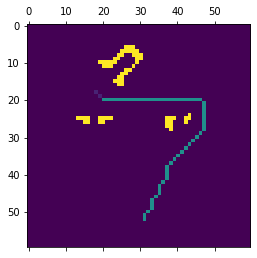

None

[2.0, 2.0500000000000003]


KeyboardInterrupt: 

In [24]:
while True:
    updateGrid(pos[0],pos[1],odom,sc)
    route = getRoute(bad,3)
    path = route.getPath()
    
    if len(path) < 3:
        break        
    
    closest = path[-2:]

    a = closest[0]
    b = closest[-1]
    v = -np.array((b.y-a.y,b.x-a.x))*fidelty/10

   
    
    result = np.copy(grid)

    for node in route.getPath():
        result[node.x,node.y] = 5

    clear_output()
    plt.matshow(result)
    display(plt.show())
    print(pos)
    
    drive(pub,v,odom)
    
    pos[0] += v[0]/fidelty
    pos[1] += v[1]/fidelty
    
    #break
    
rotate(pub,0,odom)

#import numpy as np
#result = np.copy(grid)

#for node in route.getPath():
#    result[node.x,node.y] = 5

  
    
#print(v)
#plt.matshow(result)

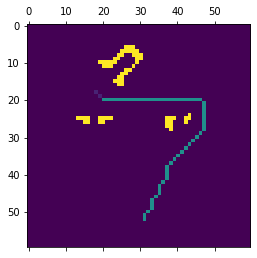

shutdown request: [/runner] Reason: new node registered with same name


In [25]:
plt.matshow(result)
plt.savefig('images/astar_B1.png', dpi=300)

In [205]:
from localisation import moveStraightForTime,rotate,abs_rotate

In [202]:
rotate(pub,-2.35,odom)

In [183]:
np.arctan2(v[0],-v[1])

-2.356194490192345

In [200]:
angle = -5.453125478454163
    
print(angle)
if abs(angle) > np.pi:
    angle = (angle+2*np.pi*np.sign(-angle))
    print(angle)   
    

-5.453125478454163
0.8300598287254228
